In [1]:
# Assignment 3 Part B -- DTW and HMM

In [2]:
# Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import time
import subprocess

from collections import Counter
from sklearn import cluster

In [3]:
# Load Train and Dev MFCCs
# Structure of train_mfcc and dev_mfcc = {digit:{filename:np_array_of_MFCC}}
INF = 9999999
digits = [2,4,6,8,9]
train_mfcc = {}
dev_mfcc = {}

for dig in digits:
    train_path = f"./IsolatedDigits/{dig}/train/"
    dev_path = f"./IsolatedDigits/{dig}/dev/"
    
    # Train MFCCs
    train_fps = os.listdir(train_path)
    mfcc_fps = [fp for fp in train_fps if fp[len(fp)-4:len(fp)] == 'mfcc']
    train_mfcc[dig] = {}
    for fp in mfcc_fps:
        fn = fp.split('.')[0]
        train_mfcc[dig][fn] = np.loadtxt(train_path+fp, skiprows=1)
    
    # Dev MFCCs
    dev_fps = os.listdir(dev_path)
    mfcc_fps = [fp for fp in dev_fps if fp[len(fp)-4:len(fp)] == 'mfcc']
    dev_mfcc[dig] = {}
    for fp in mfcc_fps:
        fn = fp.split('.')[0]
        dev_mfcc[dig][fn] = np.loadtxt(dev_path+fp, skiprows=1)

In [4]:
def cost(v1,v2,angle=False):
    '''
    Computes cost of difference between two vectors
    '''

    if not angle:
        return np.linalg.norm(v1-v2)
    else:
        diff = v2-v1
        # diff[np.where(diff>np.pi)] -= 2*np.pi
        # diff[np.where(diff<-np.pi)] += 2*np.pi
        if diff > np.pi:
            diff -= 2*np.pi 
        if diff < -np.pi:
            diff += 2*np.pi
        return np.abs(diff)

def dtw(x, y, angle=False):
    '''
    Computes DTW between sequences of MFCC vectors x and y 
    '''
    
    XLEN = len(x)
    YLEN = len(y)
    
    dp = [[INF for j in range(YLEN+1)] for i in range(XLEN+1)]
    dp[0][0] = 0

    for i in range(1,XLEN+1):
        for j in range(1,YLEN+1):
            cost_here = cost(x[i-1], y[j-1], angle)
            dp[i][j] = cost_here + min([dp[i-1][j], dp[i][j-1], dp[i-1][j-1]])
    
    return dp[-1][-1]

def majorityVoting(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

def dtwWithPath(x,y, angle=False):
    '''
    Same as dtw() but also return the warped form of y wrt x
    '''

    XLEN = len(x)
    YLEN = len(y)
    
    dp = [[[INF,i,j] for j in range(YLEN+1)] for i in range(XLEN+1)]
    dp[0][0] = [0,None,None]

    # Find DTW Matrix
    for i in range(1, XLEN+1):
        for j in range(1, YLEN+1):
            c = cost(x[i-1], y[j-1], angle)
            dp[i][j] = min([ [dp[i-1][j][0]+c, i-1, j], [dp[i][j-1][0]+c, i, j-1], [dp[i-1][j-1][0]+c, i-1, j-1]  ])

    # Extract Path
    curr = [XLEN, YLEN]
    path = [curr.copy()]
    dirs = []
    next = dp[curr[0]][curr[1]][1:]

    # ct = 0
    while next[0] != None and next[1] != None: 
        if next[0] < curr[0] and next[1] < curr[1]:
            dirs.append('J')
        elif next[1] < curr[1]:
            dirs.append('R')
        else:
            dirs.append('D')

        path.append(next.copy())
        curr = next.copy()
        next = dp[curr[0]][curr[1]][1:]

    path = path[::-1][1:]
    dirs = dirs[::-1][1:]
    
    # R : avg from curr to curr+runlength(R) inclusive
    # D : interp between curr and curr+runlength(D) inclusive, runlength(D) times

    # CWRT
    # Resolve all Rs first, they are avgs and their endpoints dont change
    # Then resolve Ds using the updated endpoints. Helps in case of ...DR...
    
    # Resolving Rs
    new_dirs = []
    warped_y = []
    R_run = 0
    D_run = 0
    ptr = 0
    for dir_ind in range(len(dirs)):
        dir = dirs[dir_ind]
        if dir == 'J':
            new_dirs.append('J')
            if R_run != 0:
                warped_y.append(np.mean(y[ptr-R_run:ptr+1], axis=0))
                R_run = 0
            elif D_run != 0:
                warped_y.append(y[ptr])
                D_run = 0
            else:
                warped_y.append(y[ptr])
            ptr+=1
        elif dir == 'R':
            R_run += 1
            ptr += 1
        else: # dir == 'D'
            D_run += 1
            new_dirs.append('D')
    if D_run != 0:
        warped_y.append(y[ptr])
        
    elif R_run != 0:
        warped_y.append(np.mean(y[ptr-R_run:ptr+1], axis=0))
    
    warped_y.append(y[-1])
    dirs = new_dirs.copy()

    # Resolving Ds
    y = warped_y.copy()
    warped_y = []
    D_run = 0
    ptr = 0
    for dir_ind in range(len(dirs)):
        dir = dirs[dir_ind]
        if dir == 'J':
            if D_run != 0:
                interps = np.linspace(y[ptr], y[ptr+1], D_run+2)[:-1]
                interps = [interps[ind] for ind in range(interps.shape[0])]
                warped_y.extend(interps)
                D_run = 0
                ptr+=1
            else:
                warped_y.append(y[ptr])
                ptr+=1
        else: # dir == 'D'
            D_run += 1
    if D_run != 0:
        interps = np.linspace(y[ptr], y[ptr+1], D_run+2)[:-1]
        interps = [interps[ind] for ind in range(interps.shape[0])]
        warped_y.extend(interps)
        D_run = 0
    else:
        warped_y.append(y[-1])
    
    return dp[-1][-1], warped_y


In [5]:
# test_arr1 = np.array([1,7,3,4,1,10,5,4,7,4])
# test_arr2 = np.array([1,4,5,10,9,3,2,6,8,4])
# print(cost(test_arr1[1],test_arr2[1]))
# res = dtwWithPath(test_arr1, test_arr2)
# print(f"warped y: {res[1]}")

In [6]:
def getTemplates(train_mfcc, angle=False):
    '''
    Computes a reference template for each class using CWRT
    '''

    templ = {dig:None for dig in train_mfcc.keys()}
    for dig in train_mfcc.keys():
        
        dig_fns = sorted(train_mfcc[dig].keys())
        init_templ = train_mfcc[dig][dig_fns[0]]
        warped_collection = [init_templ]
        for fn in dig_fns[1:]:
            mfcc_here = train_mfcc[dig][fn]
            res = dtwWithPath(init_templ, mfcc_here, angle)
            warped_mfcc_here = res[1]
            
            warped_collection.append(warped_mfcc_here)
            
        # print('shapes:', [len(arr) for arr in warped_collection])
        new_templ = np.mean(np.array(warped_collection), axis=0)
        templ[dig] = new_templ
    
    return templ
            

In [7]:
# Warp kc of Nc train examples of class c to same audio, then average
templ = getTemplates(train_mfcc)
print("Templates Built")

Templates Built


In [8]:
# Compute DTW error, get majority votes of top K, get class

def predictCWRT(train_mfcc, dev_mfcc, angle=False):

    t1 = time.time()
    correct = 0
    total = 0
    for dev_dig in dev_mfcc.keys():
        for dev_fn in dev_mfcc[dev_dig].keys():
            dev_frames = dev_mfcc[dev_dig][dev_fn]
            print(f"Dev {dev_fn} prediction: ", end = '')
            
            dig_best = None
            err_best = INF
            errs = []
            for train_dig in train_mfcc.keys():
                template = templ[train_dig]
                err_here = dtw(template, dev_frames, angle)
                if err_here < err_best:
                    err_best = err_here
                    dig_best = train_dig
            
            print(dig_best)
            if dig_best == dev_dig:
                correct+=1
            else:
                print(f"Failed, true: {dev_dig}, pred: {dig_best}")
            
            total += 1
    
    t2 = time.time()
    acc = correct/total
    print(f"Acc: {acc}")
    print("Time taken: {:.4f} sec".format(t2-t1))

def predict(train_mfcc, dev_mfcc, angle=False):
    t1 = time.time()
    K = 5
    correct = 0
    total = 0
    for dev_dig in dev_mfcc.keys():
        for dev_fn in dev_mfcc[dev_dig].keys():
            dev_frames = dev_mfcc[dev_dig][dev_fn]
            print(f"Dev {dev_fn} prediction: ", end = '')
            
            dig_best = None
            err_best = INF
            errs = []
            for train_dig in train_mfcc.keys():
            
                for train_fn in train_mfcc[train_dig].keys():
                    
                    train_frames = train_mfcc[train_dig][train_fn]
                    err_here = dtw(train_frames, dev_frames, angle)
                    errs.append([err_here, train_dig])
            
            topK = sorted(errs)[:K]
            topK_digs = [val[1] for val in topK]
            dig_best = majorityVoting(topK_digs)
            
            print(dig_best)
            if dig_best == dev_dig:
                correct+=1
                print("Passed, votes:", topK_digs)
            else:
                print("Failed, votes:", topK_digs)
            total += 1
    
    t2 = time.time()
    acc = correct/total
    print(f"Acc: {acc}")
    print("Time taken: {:.4f} sec".format(t2-t1))


In [9]:
# predict(train_mfcc, dev_mfcc)
predictCWRT(train_mfcc, dev_mfcc)

Dev mk_2 prediction: 2
Dev mm_2 prediction: 2
Dev ms_2 prediction: 2
Dev mw_2 prediction: 2
Dev nc_2 prediction: 2
Dev ng_2 prediction: 2
Dev nh_2 prediction: 2
Dev pe_2 prediction: 2
Dev pk_2 prediction: 2
Dev pm_2 prediction: 2
Dev pp_2 prediction: 2
Dev ra_2 prediction: 2
Dev mk_4 prediction: 4
Dev mm_4 prediction: 4
Dev ms_4 prediction: 4
Dev mw_4 prediction: 4
Dev nc_4 prediction: 4
Dev ng_4 prediction: 4
Dev nh_4 prediction: 4
Dev pe_4 prediction: 4
Dev pk_4 prediction: 4
Dev pm_4 prediction: 4
Dev pp_4 prediction: 4
Dev ra_4 prediction: 4
Dev mk_6 prediction: 6
Dev mm_6 prediction: 6
Dev ms_6 prediction: 6
Dev mw_6 prediction: 6
Dev nc_6 prediction: 6
Dev ng_6 prediction: 6
Dev nh_6 prediction: 6
Dev pe_6 prediction: 6
Dev pk_6 prediction: 6
Dev pm_6 prediction: 6
Dev pp_6 prediction: 6
Dev ra_6 prediction: 6
Dev mk_8 prediction: 8
Dev mm_8 prediction: 8
Dev ms_8 prediction: 8
Dev mw_8 prediction: 8
Dev nc_8 prediction: 8
Dev ng_8 prediction: 8
Dev nh_8 prediction: 8
Dev pe_8 pr

In [ ]:
# MFCC DTW Plots

# Plot ROC


# Plot DET


# Plot Confusion Matrix

In [10]:
# Online Handwritten Character Recognition

def loadHW(path, angle=False):
    f = open(path, 'r')
    data = f.readline().split()[1:]
    data = [float(v) for v in data]
    feats = []
    for i in range(int(len(data)/2)):
        feats.append(np.array([data[2*i], data[2*i + 1]]))
    
    if angle:
        vecs = np.diff(np.array(feats), axis=0)
        angles = np.arctan2(vecs[:,1], vecs[:,0])
        return angles
    else:
        return feats

In [11]:
letters = ['a', 'ai', 'bA', 'chA', 'dA']
hwr_angle = True

# Load Train and Dev MFCCs
# Structure of train_mfcc and dev_mfcc = {digit:{filename:np_array_of_MFCC}}

train_feats = {}
dev_feats = {}

for let in letters:
    train_path = f"./HandwritingData/{let}/train/"
    dev_path = f"./HandwritingData/{let}/dev/"
    
    # Train MFCCs
    train_fps = os.listdir(train_path)
    train_feats[let] = {}
    for fp in train_fps:
        fn = fp.split('.')[0]

        feats_here = loadHW(train_path+fp, hwr_angle)
        feats_here = np.array(feats_here)
        if not hwr_angle:
            feats_here = feats_here - np.mean(feats_here, axis=0)
            feats_here = feats_here/np.sqrt(np.var(feats_here, axis=0))

        train_feats[let][fn] = feats_here
    
    # Dev MFCCs
    dev_fps = os.listdir(dev_path)
    dev_feats[let] = {}
    for fp in dev_fps:
        fn = fp.split('.')[0]

        feats_here = loadHW(dev_path+fp, hwr_angle)
        feats_here = np.array(feats_here)
        if not hwr_angle:
            feats_here = feats_here - np.mean(feats_here, axis=0)
            feats_here = feats_here/np.sqrt(np.var(feats_here, axis=0))

        dev_feats[let][fn] = feats_here

In [13]:
# Just exploring the data
if not hwr_angle:
    eg_ct = 1
    for let in train_feats.keys():
        for fn in list(train_feats[let].keys())[:eg_ct]:
            pts = train_feats[let][fn]
            x_pts = [v[0] for v in pts]
            y_pts = [v[1] for v in pts]

            plt.figure()
            plt.scatter(x_pts,y_pts)
            plt.title(f"Plot of character {let} from file {fn}")
            plt.show()

In [14]:
templ = getTemplates(train_feats, angle=hwr_angle)
print("Templates Built")

Templates Built


In [15]:
predictCWRT(train_feats, dev_feats, angle=hwr_angle)
# predict(train_feats, dev_feats, angle=hwr_angle)

Dev 70 prediction: a
Dev 71 prediction: a
Dev 72 prediction: a
Dev 73 prediction: a
Dev 74 prediction: a
Dev 75 prediction: a
Dev 76 prediction: a
Dev 77 prediction: a
Dev 78 prediction: a
Dev 79 prediction: a
Dev 80 prediction: a
Dev 81 prediction: a
Dev 82 prediction: a
Dev 83 prediction: a
Dev 84 prediction: a
Dev 85 prediction: a
Dev 86 prediction: a
Dev 87 prediction: a
Dev 88 prediction: a
Dev 89 prediction: a
Dev 70 prediction: ai
Dev 71 prediction: ai
Dev 72 prediction: ai
Dev 73 prediction: ai
Dev 74 prediction: ai
Dev 75 prediction: ai
Dev 76 prediction: ai
Dev 77 prediction: ai
Dev 78 prediction: ai
Dev 79 prediction: ai
Dev 80 prediction: ai
Dev 81 prediction: ai
Dev 82 prediction: ai
Dev 83 prediction: ai
Dev 84 prediction: ai
Dev 85 prediction: ai
Dev 86 prediction: ai
Dev 87 prediction: ai
Dev 88 prediction: ai
Dev 89 prediction: ai
Dev 67 prediction: bA
Dev 68 prediction: bA
Dev 69 prediction: bA
Dev 70 prediction: chA
Failed, true: bA, pred: chA
Dev 71 prediction: bA
D

In [ ]:
# HWR DTW Plots

# Plot ROC


# Plot DET


# Plot Confusion Matrix

In [16]:
# Discrete HMM

# 1. Use vector quantization (k-means) to convert feature vecs to symbols
# 2. Store train and test symbol seqs in files
# 3. Use HMM C++ code to train on train seqs, build model
# 4. Use HMM C++ code to eval trained model on test seqs

In [17]:
# Vector Quantization using k-means

def k_means(data,k=15):
    # reshape data for numpy broadcasting
    data = np.reshape(data,[-1,1,data.shape[-1]])
    # initialize k means with random means
    myrange = np.linspace(0,data.shape[0]-1,k,dtype = np.int64)
    kmeans = np.vstack([data[myrange,0,i] for i in range(0,data.shape[-1])]).T
    # reshape data for numpy broadcasting
    kmeans = np.reshape(kmeans,[1,-1,kmeans.shape[-1]])
    # calculate distances
    dists = np.sum((data - kmeans)**2,axis=2)
    # initialize cluster assignments
    
    # choose n rows from a kxk identity matrix 
    # using an nx1 argmin matrix (ranging from 0 to k-1)
    # to produce an nxk 1-hot encoded matrix
    r_nk_old = np.eye(k)[np.argmin(dists,axis=1)]
    r_nk_new = r_nk_old.copy()
    c = 0
    while True:
        #print(f"Iteration {c}")
        c+=1
        # move cluster assignments into old variable for comparison
        r_nk_old = r_nk_new.copy()
        # update means
        if np.any(np.sum(r_nk_old,axis=0) == 0):
            print(r_nk_old)
            print("error, 0 sum encountered")
            break
        kmeans = (r_nk_old.T @ np.squeeze(data))/np.reshape(np.sum(r_nk_old,axis=0),[-1,1])
        # update new cluster assignments
        dists = np.sum((data - kmeans)**2,axis=2)
        r_nk_new = np.eye(k)[np.argmin(dists,axis=1)]
        # test for convergence
        if np.all(r_nk_old == r_nk_new):
            break
    print(f"Iterations to convergence = {c}")
    # print(f"r_nk shape: {r_nk_new.shape}")
    r_nk_int = np.argmax(r_nk_new, axis=1)
    return kmeans, r_nk_new, r_nk_int


# def k_means_sklearn(feats, k=15):
#     '''
#     Performs k-means on elements of feats, returns cluster centres
#     '''

#     km_inst = cluster.KMeans(n_clusters=k, random_state=1)
#     km_inst.fit(feats)
#     return km_inst.cluster_centers_, km_inst.labels_

def quantize_with_means(feats, means):
    '''
    Quantizes each example, given k-means centres
    '''

    labels = {}
    for cl in feats.keys():
        labels[cl] = {}
        for fn in sorted(list(feats[cl].keys())):
            labels[cl][fn] = []
            feats_here = feats[cl][fn]
            if len(feats_here.shape) == 1:
                feats_here = np.reshape(feats_here, [-1,1])
            
            for feat in feats_here:
                min_norm = INF
                for m_id in range(len(means)):
                    # print("feat:", feat)
                    # print("means:", means)
                    norm_here = np.linalg.norm(feat-means[m_id])
                    if norm_here < min_norm:
                        min_norm = norm_here
                        feat_sym = m_id
                labels[cl][fn].append(feat_sym)
    return labels

def quantize_train(train_feats, k=15):
    '''
    Quantizes real valued vectors into symbols derived from k-means cluster centres
    '''

    # Take all vectors across files for particular class. Do k-means on that
    # For eg in handwriting, this means -- take one letter, do k-means on all instances of that letter
    
    means = None
    syms = {}
    all_feats = []
    tot = 0
    bd = {}
    cls = sorted(list(train_feats.keys()))
    for cl in cls:
        fns = sorted(list(train_feats[cl].keys()))
        if len(train_feats[cl][fns[0]].shape) == 1:
            class_feats = np.concatenate([np.reshape(train_feats[cl][fn], [-1,1]) for fn in fns])
        else:
            class_feats = np.concatenate([train_feats[cl][fn] for fn in fns])
        bounds = np.array([len(train_feats[cl][fn]) for fn in fns])
        bounds = [0] + list(np.cumsum(bounds))
        bd[cl] = {fns[i]:[bounds[i]+tot,bounds[i+1]+tot] for i in range(len(fns))}
        all_feats.append(class_feats)
        tot += len(class_feats)
    
    all_feats = np.concatenate(all_feats)
    # means, syms = k_means_sklearn(all_feats)
    means, syms_onehot, syms = k_means(all_feats, k)

    symd = {}
    for cl in train_feats.keys():
        symd[cl] = {}
        fns = sorted(list(train_feats[cl].keys()))
        for fn in fns:
            symd[cl][fn] = syms[bd[cl][fn][0]:bd[cl][fn][1]]
    
    return means, symd

def write_syms(symd, pref='dummy'):
    '''
    Write quantized symbols into seq file for HMM C++
    Set pref to 'train' or 'dev'
    '''

    try:
        os.mkdir(f'./HMM-Code/{pref}')
    except FileExistsError:
        pass
    
    for cl in symd.keys():
        out_str = ""
        for fn in symd[cl].keys():
            out_str += " ".join(str(char) for char in symd[cl][fn])
            out_str += "\n"

        with open(f'./HMM-Code/{pref}/{cl}.txt', 'w') as fo:
            fo.write(out_str)

In [46]:
letters = ['a', 'ai', 'bA', 'chA', 'dA']
hwr_angle = False

# Load Train and Dev Letters
# Structure of train_feats and dev_feats = {digit:{filename:np_array_of_feats}}

train_feats = {}
dev_feats = {}

for let in letters:
    train_path = f"./HandwritingData/{let}/train/"
    dev_path = f"./HandwritingData/{let}/dev/"
    
    # Train MFCCs
    train_fps = os.listdir(train_path)
    train_feats[let] = {}
    for fp in train_fps:
        fn = fp.split('.')[0]

        feats_here = loadHW(train_path+fp, hwr_angle)
        feats_here = np.array(feats_here)
        if not hwr_angle:
            feats_here = feats_here - np.mean(feats_here, axis=0)
            feats_here = feats_here/np.sqrt(np.var(feats_here, axis=0))

        train_feats[let][fn] = feats_here
    
    # Dev MFCCs
    dev_fps = os.listdir(dev_path)
    dev_feats[let] = {}
    for fp in dev_fps:
        fn = fp.split('.')[0]

        feats_here = loadHW(dev_path+fp, hwr_angle)
        feats_here = np.array(feats_here)
        if not hwr_angle:
            feats_here = feats_here - np.mean(feats_here, axis=0)
            feats_here = feats_here/np.sqrt(np.var(feats_here, axis=0))

        dev_feats[let][fn] = feats_here

def generate_model_files():
    pass

Starting K=5
Iterations to convergence = 98
Probabs Generated
Acc: 0.83


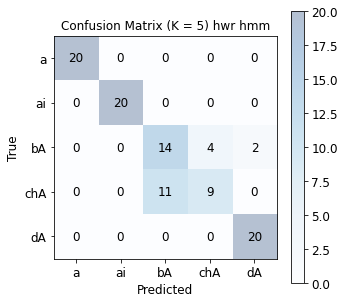

Starting K=6
Iterations to convergence = 103
Probabs Generated
Acc: 0.91


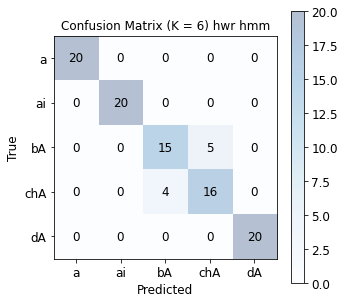

Starting K=7
Iterations to convergence = 72
Probabs Generated
Acc: 0.95


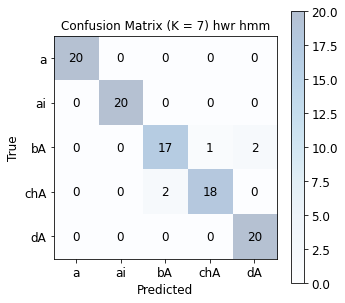

Starting K=8
Iterations to convergence = 54
Probabs Generated
Acc: 0.91


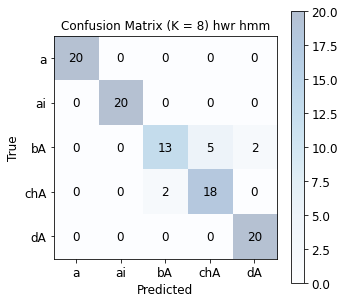

Starting K=9
Iterations to convergence = 217
Probabs Generated
Acc: 0.94


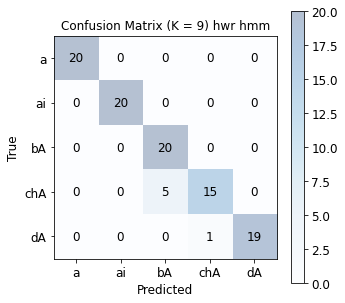

Starting K=10
Iterations to convergence = 114
Probabs Generated
Acc: 0.92


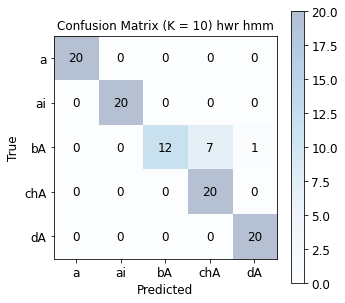

Starting K=11
Iterations to convergence = 196
Probabs Generated
Acc: 0.87


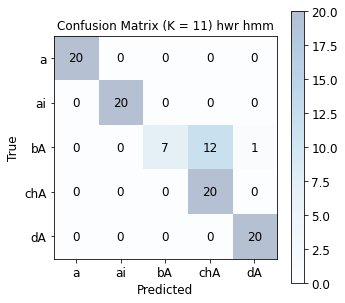

Starting K=12
Iterations to convergence = 130
Probabs Generated
Acc: 0.92


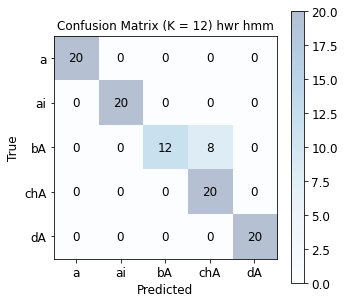

Starting K=13
Iterations to convergence = 66
Probabs Generated
Acc: 0.94


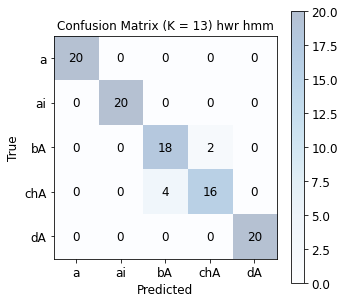

Starting K=14
Iterations to convergence = 51
Probabs Generated
Acc: 0.98


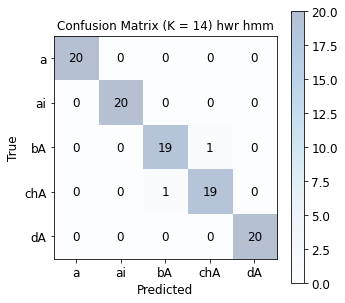

Starting K=15
Iterations to convergence = 52
Probabs Generated
Acc: 0.91


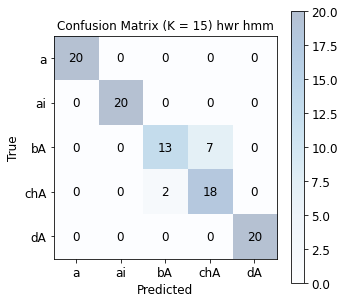

Starting K=16
Iterations to convergence = 199
Probabs Generated
Acc: 0.87


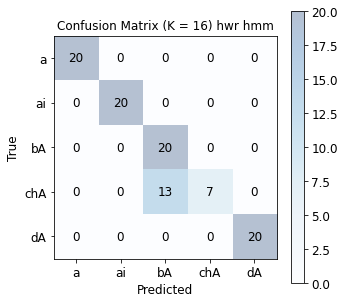

Starting K=17
Iterations to convergence = 197
Probabs Generated
Acc: 0.99


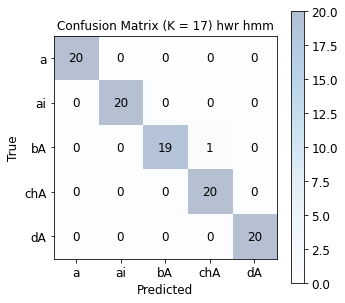

Starting K=18
Iterations to convergence = 91
Probabs Generated
Acc: 0.89


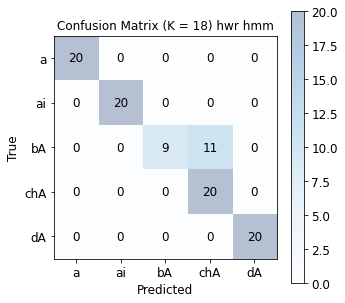

Starting K=19
Iterations to convergence = 143
Probabs Generated
Acc: 0.97


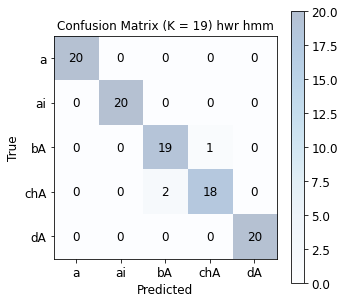

Starting K=20
Iterations to convergence = 76
Probabs Generated
Acc: 0.99


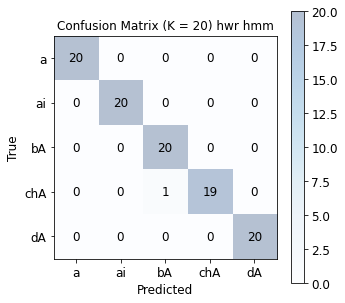

Starting K=21
Iterations to convergence = 216
Probabs Generated
Acc: 0.8


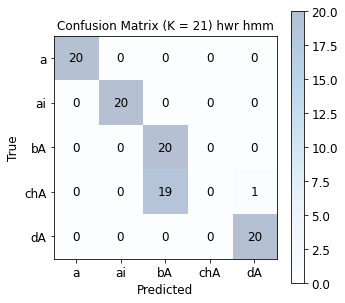

Starting K=22
Iterations to convergence = 133
Probabs Generated
Acc: 0.6


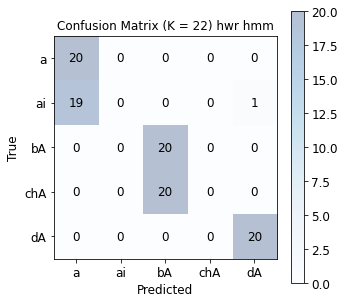

Starting K=23
Iterations to convergence = 148
Probabs Generated
Acc: 0.6


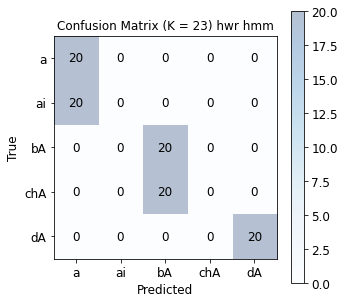

Starting K=24
Iterations to convergence = 42
Probabs Generated
Acc: 0.4


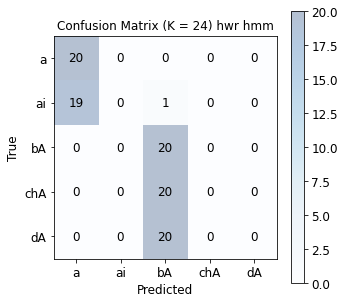

In [47]:
# HWR HMM
# K = 10
acc_vs_k = []
pr_type = 'hwr'
algo = 'hmm'
k_range = list(range(5,25))
posts_ll = {}
sorted_cls = sorted(list(train_feats.keys()))
cl_to_ind = {cl:sorted_cls.index(cl) for cl in sorted_cls}
for K in k_range:
    print(f"Starting K={K}")

    # List of copy examples for ROC calc later
    posts_ll[K] = []
    posts_list_k = []

    cl_ct = len(list(train_feats.keys()))

    # Quantized
    means_train, syms_train = quantize_train(train_feats, K)
    # print(means_train)
    syms_dev = quantize_with_means(dev_feats, means_train)

    # Write symbols to sequences file for HMM C++
    write_syms(syms_train, f'{pr_type}_train')
    write_syms(syms_dev, f'{pr_type}_dev')

    # Set initial params for each class-specific HMM
    # Assume left-to-right HMM, and each state modelled by unimodal Gaussian
    # So num_states = num_symbols = k in k-means used earlier to cluster vectors 

    # Call HMM C++ trainer, get trained models for each class
    for cl in sorted(list(train_feats.keys())):

        sp = subprocess.run(["wsl", "cd", "HMM-Code;", "./train_hmm", f"./{pr_type}_train/{cl}.txt", "1234", f"{K}", f"{K}", "0.01"], shell=True, capture_output=True)
        # print(sp.stdout.decode('utf-8'))
        # print("Errors:", sp.stderr.decode('utf-8'))

    # Test on dev seqs, get probabs from each HMM, predict with argmax
    preds = {}
    for dev_cl in sorted(list(dev_feats.keys())):
        dev_cl_fns = sorted(list(dev_feats[dev_cl].keys()))
        dev_cl_fns_ind = {dev_fn:dev_cl_fns.index(dev_fn) for dev_fn in dev_cl_fns}
        preds[dev_cl] = {dev_ex:{} for dev_ex in dev_cl_fns}
        for train_cl in sorted(list(train_feats.keys())):
            sp = subprocess.run(["wsl", "cd", "HMM-Code;", "./test_hmm", f"./{pr_type}_dev/{dev_cl}.txt", f"./{pr_type}_train/{train_cl}.txt.hmm"], shell=True, capture_output=True)
            # print(sp.stdout.decode('utf-8'))
            out = sp.stdout.decode('utf-8')
            out_lst = out.split('\n')
            out_lst = [line for line in out_lst if line[:5]=='alpha']
            out_lst = [float(line.split(' ')[4]) for line in out_lst]
            # print(out_lst)
            
            for dev_ex in dev_cl_fns:
                preds[dev_cl][dev_ex][train_cl] = out_lst[dev_cl_fns_ind[dev_ex]]
                posts_list_k.append([out_lst[dev_cl_fns_ind[dev_ex]],train_cl,dev_cl])
            # print("Errors (if any):", sp.stderr.decode('utf-8'))
            # print("-----------------------------------------------")
    print("Probabs Generated")

    correct = 0
    total = 0
    conf_mat = np.zeros([cl_ct, cl_ct])
    preds_keys = sorted(list(preds.keys()))
    for i in range(cl_ct):
        dev_cl = preds_keys[i]
        preds_cl_keys = sorted(list(preds[dev_cl].keys()))
        for j in range(len(preds_cl_keys)):
            dev_fn = preds_cl_keys[j]
            probs_here = preds[dev_cl][dev_fn]
            pred_cl = max(probs_here, key=probs_here.get)
            conf_mat[i,cl_to_ind[pred_cl]] += 1
            if pred_cl == dev_cl:
                correct += 1
            total += 1
    acc = correct/total
    print(f"Acc: {acc}")
    acc_vs_k.append(acc)

    posts_ll[K] = posts_list_k.copy()
    # Plot Confusion Matrix
    sf = 2
    fig = plt.figure(figsize=(2.5*sf,2.5*sf))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3, 
                    interpolation='nearest')

    width, height = conf_mat.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(int(conf_mat[x][y])), xy=(y, x), ha='center', va='center', size=6*sf)

    cb = fig.colorbar(res)
    cb.ax.tick_params(labelsize=6*sf)
    plt.xticks(range(width), sorted_cls, fontsize=6*sf)
    plt.yticks(range(height), sorted_cls, fontsize=6*sf)
    plt.xlabel('Predicted', fontsize=6*sf)
    plt.ylabel('True', fontsize=6*sf)
    plt.title(f"Confusion Matrix (K = {K}) {pr_type} {algo}", fontsize=6*sf)
    plt.savefig(f'./Plots/conf_{pr_type}_{algo}_{K}.png', format='png')
    plt.show()

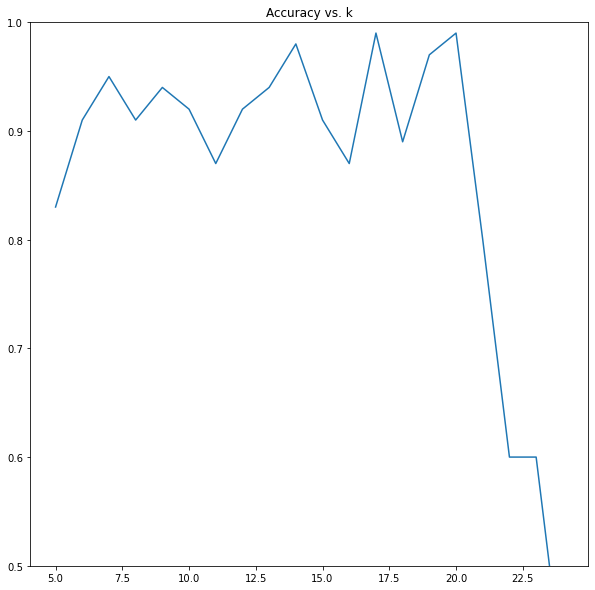

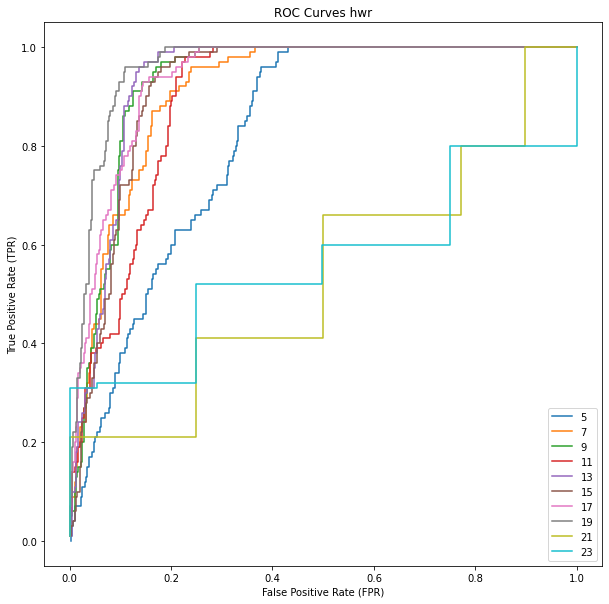

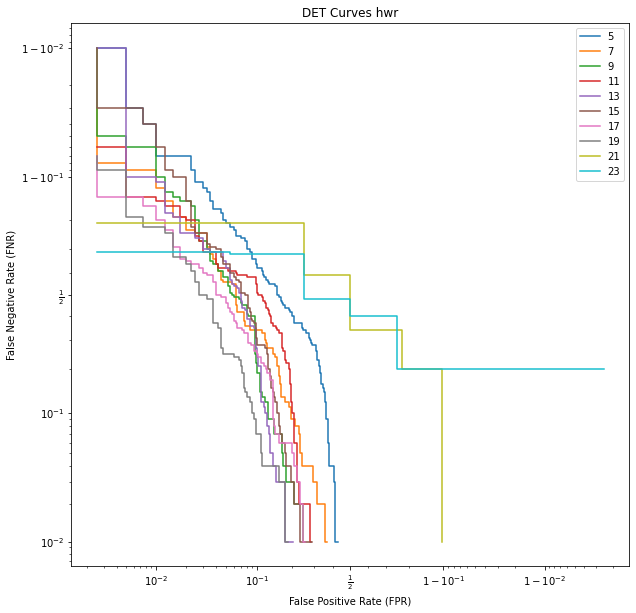

In [50]:
# HWR HMM Plots (Acc vs k, ROC, DET)
plt.figure(figsize=[10,10])
plt.plot(k_range, acc_vs_k)
plt.title("Accuracy vs. k")
plt.ylim(0.5,1.0)
plt.savefig(f"./Plots/Acc_vs_k_{pr_type}_{algo}.png")
plt.show()

# Plot ROC for select k
str_k_range = [str(v) for v in k_range]
fig1, ax1 = plt.subplots(figsize=[10,10])
fig2, ax2 = plt.subplots(figsize=[10,10])

skip = 2

# Sort in ascending order
for case in range(len(k_range)):
    K = k_range[case]
    posts_list = posts_ll[K]
    posts_list = sorted(posts_list)
    # print(posts_list)
    roc_pts = [[0,0]]
    fp_total = []
    tp_fn_cts = [0]  #  tp_fn_cts[i] = no. of examples left of (and excluding) i which can be only tp or fn
    tn_fp_cts = [0]

    for i in range(len(posts_list)):
        post_here = posts_list[i]
        if post_here[1] == post_here[2]:
            tp_fn_cts.append(tp_fn_cts[-1] + 1)
            tn_fp_cts.append(tn_fp_cts[-1])
        else:
            tp_fn_cts.append(tp_fn_cts[-1])
            tn_fp_cts.append(tn_fp_cts[-1] + 1)

    # print(tp_fn_cts)
    # print(tn_fp_cts)
    tp_fn_tot = tp_fn_cts[-1]
    tn_fp_tot = tn_fp_cts[-1]
    tpr = []
    fpr = []
    tnr = []
    fnr = []
    ex_ct = len(posts_list)
    for i in range(len(posts_list)):

        thresh = posts_list[i][0]
        tpr.append((tp_fn_tot - tp_fn_cts[i])/tp_fn_tot)
        fpr.append((tn_fp_tot - tn_fp_cts[i])/tn_fp_tot)
        tnr.append(tn_fp_cts[i]/tn_fp_tot)
        fnr.append(tp_fn_cts[i]/tp_fn_tot)

    # roc_pts = [[fpr[i],tpr[i]] for i in range(len(tpr))]
    if case%skip == 0:
        ax1.plot(fpr, tpr)
        ax2.plot(fpr, fnr)
ax1.legend(str_k_range[::skip])
ax2.legend(str_k_range[::skip])
ax1.set_xlabel('False Positive Rate (FPR)')
ax1.set_ylabel('True Positive Rate (TPR)')

ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('False Negative Rate (FNR)')

ax2.set_xscale('logit')
ax2.set_yscale('logit')

# scale = 2
# ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale))
# ax2.xaxis.set_major_formatter(ticks)
# ax2.yaxis.set_major_formatter(ticks)

ax1.set_title("ROC Curves " + pr_type)
ax2.set_title("DET Curves " + pr_type)

fig1.savefig(f"./Plots/ROC_{pr_type}_{algo}.png")
fig2.savefig(f"./Plots/DET_{pr_type}_{algo}.png")
plt.show()


# Plot DET for select k

In [28]:
# Load Train and Dev MFCCs
# Structure of train_mfcc and dev_mfcc = {digit:{filename:np_array_of_MFCC}}
INF = 9999999
digits = [2,4,6,8,9]
train_mfcc = {}
dev_mfcc = {}

for dig in digits:
    train_path = f"./IsolatedDigits/{dig}/train/"
    dev_path = f"./IsolatedDigits/{dig}/dev/"
    
    # Train MFCCs
    train_fps = os.listdir(train_path)
    mfcc_fps = [fp for fp in train_fps if fp[len(fp)-4:len(fp)] == 'mfcc']
    train_mfcc[dig] = {}
    for fp in mfcc_fps:
        fn = fp.split('.')[0]
        train_mfcc[dig][fn] = np.loadtxt(train_path+fp, skiprows=1)
    
    # Dev MFCCs
    dev_fps = os.listdir(dev_path)
    mfcc_fps = [fp for fp in dev_fps if fp[len(fp)-4:len(fp)] == 'mfcc']
    dev_mfcc[dig] = {}
    for fp in mfcc_fps:
        fn = fp.split('.')[0]
        dev_mfcc[dig][fn] = np.loadtxt(dev_path+fp, skiprows=1)

train_feats = train_mfcc
dev_feats = dev_mfcc

Starting K=5
Iterations to convergence = 28
Probabs Generated
Acc: 0.8


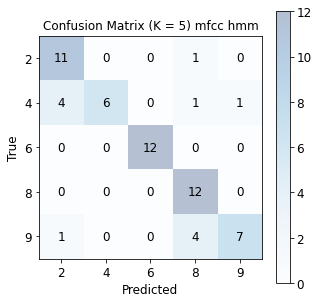

Starting K=6
Iterations to convergence = 24
Probabs Generated
Acc: 0.8333333333333334


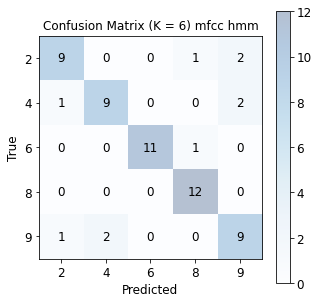

Starting K=7
Iterations to convergence = 78
Probabs Generated
Acc: 0.8833333333333333


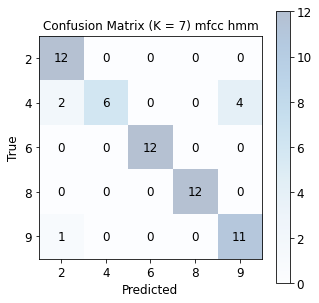

Starting K=8
Iterations to convergence = 46
Probabs Generated
Acc: 0.8666666666666667


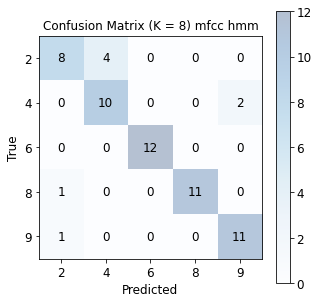

Starting K=9
Iterations to convergence = 92
Probabs Generated
Acc: 0.9166666666666666


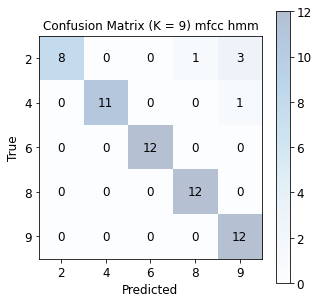

Starting K=10
Iterations to convergence = 36
Probabs Generated
Acc: 0.9333333333333333


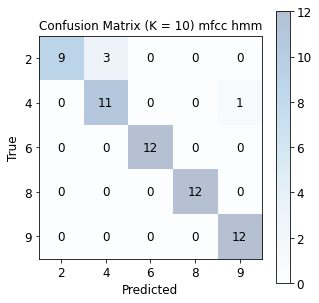

Starting K=11
Iterations to convergence = 71
Probabs Generated
Acc: 0.9833333333333333


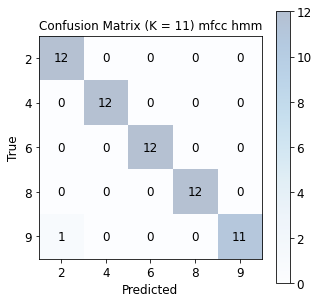

Starting K=12
Iterations to convergence = 79
Probabs Generated
Acc: 0.9833333333333333


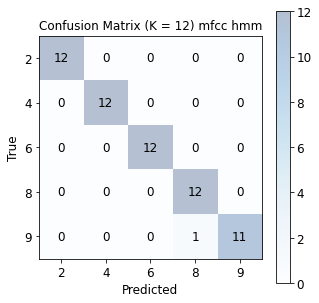

Starting K=13
Iterations to convergence = 59
Probabs Generated
Acc: 0.9


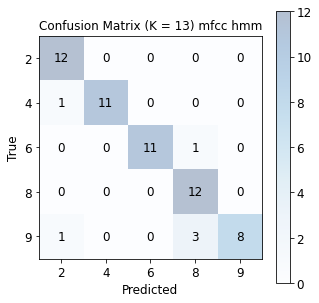

Starting K=14
Iterations to convergence = 54
Probabs Generated
Acc: 1.0


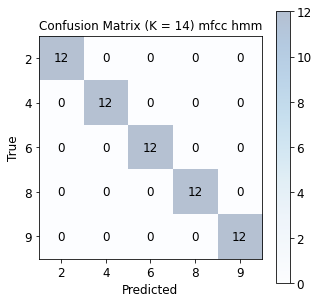

Starting K=15
Iterations to convergence = 81
Probabs Generated
Acc: 0.9833333333333333


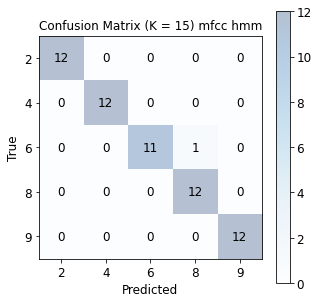

Starting K=16
Iterations to convergence = 55
Probabs Generated
Acc: 1.0


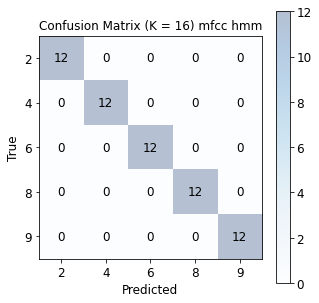

Starting K=17
Iterations to convergence = 160
Probabs Generated
Acc: 0.9833333333333333


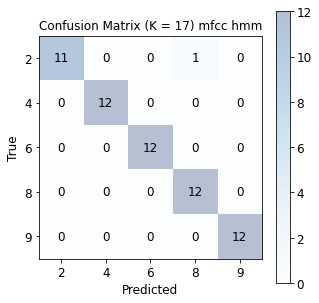

Starting K=18
Iterations to convergence = 76
Probabs Generated
Acc: 1.0


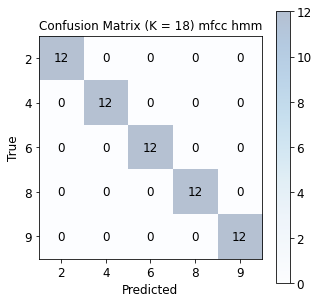

Starting K=19
Iterations to convergence = 78
Probabs Generated
Acc: 0.9833333333333333


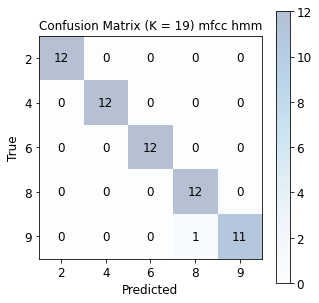

Starting K=20
Iterations to convergence = 53
Probabs Generated
Acc: 0.9833333333333333


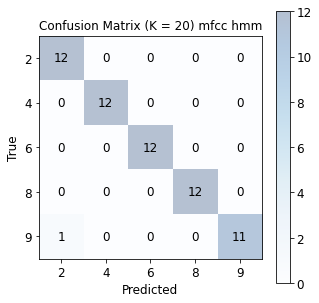

Starting K=21
Iterations to convergence = 70
Probabs Generated
Acc: 0.9833333333333333


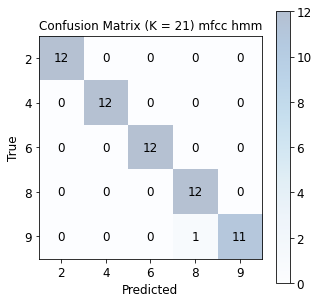

Starting K=22
Iterations to convergence = 109
Probabs Generated
Acc: 0.9833333333333333


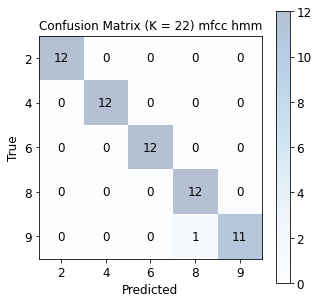

Starting K=23
Iterations to convergence = 116
Probabs Generated
Acc: 1.0


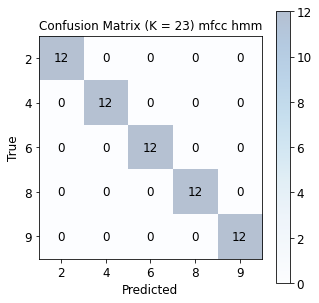

Starting K=24
Iterations to convergence = 110
Probabs Generated
Acc: 1.0


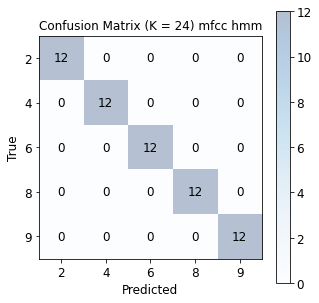

In [44]:
# MFCC HMM
# K = 10
acc_vs_k = []
pr_type = 'mfcc'
algo = 'hmm'
k_range = list(range(5,25))
posts_ll = {}
sorted_cls = sorted(list(train_feats.keys()))
cl_to_ind = {cl:sorted_cls.index(cl) for cl in sorted_cls}
for K in k_range:
    print(f"Starting K={K}")

    # List of copy examples for ROC calc later
    posts_ll[K] = []
    posts_list_k = []

    cl_ct = len(list(train_feats.keys()))

    # Quantized
    means_train, syms_train = quantize_train(train_feats, K)
    # print(means_train)
    syms_dev = quantize_with_means(dev_feats, means_train)

    # Write symbols to sequences file for HMM C++
    write_syms(syms_train, 'mfcc_train')
    write_syms(syms_dev, 'mfcc_dev')

    # Set initial params for each class-specific HMM
    # Assume left-to-right HMM, and each state modelled by unimodal Gaussian
    # So num_states = num_symbols = k in k-means used earlier to cluster vectors 

    # Call HMM C++ trainer, get trained models for each class
    for cl in sorted(list(train_feats.keys())):

        sp = subprocess.run(["wsl", "cd", "HMM-Code;", "./train_hmm", f"./{pr_type}_train/{cl}.txt", "1234", f"{K}", f"{K}", "0.01"], shell=True, capture_output=True)
        # print(sp.stdout.decode('utf-8'))
        # print("Errors:", sp.stderr.decode('utf-8'))

    # Test on dev seqs, get probabs from each HMM, predict with argmax
    preds = {}
    for dev_cl in sorted(list(dev_feats.keys())):
        dev_cl_fns = sorted(list(dev_feats[dev_cl].keys()))
        dev_cl_fns_ind = {dev_fn:dev_cl_fns.index(dev_fn) for dev_fn in dev_cl_fns}
        preds[dev_cl] = {dev_ex:{} for dev_ex in dev_cl_fns}
        for train_cl in sorted(list(train_feats.keys())):
            sp = subprocess.run(["wsl", "cd", "HMM-Code;", "./test_hmm", f"./{pr_type}_dev/{dev_cl}.txt", f"./{pr_type}_train/{train_cl}.txt.hmm"], shell=True, capture_output=True)
            # print(sp.stdout.decode('utf-8'))
            out = sp.stdout.decode('utf-8')
            out_lst = out.split('\n')
            out_lst = [line for line in out_lst if line[:5]=='alpha']
            out_lst = [float(line.split(' ')[4]) for line in out_lst]
            # print(out_lst)
            
            for dev_ex in dev_cl_fns:
                preds[dev_cl][dev_ex][train_cl] = out_lst[dev_cl_fns_ind[dev_ex]]
                posts_list_k.append([out_lst[dev_cl_fns_ind[dev_ex]],train_cl,dev_cl])
            # print("Errors (if any):", sp.stderr.decode('utf-8'))
            # print("-----------------------------------------------")
    print("Probabs Generated")

    correct = 0
    total = 0
    conf_mat = np.zeros([cl_ct, cl_ct])
    preds_keys = sorted(list(preds.keys()))
    for i in range(cl_ct):
        dev_cl = preds_keys[i]
        preds_cl_keys = sorted(list(preds[dev_cl].keys()))
        for j in range(len(preds_cl_keys)):
            dev_fn = preds_cl_keys[j]
            probs_here = preds[dev_cl][dev_fn]
            pred_cl = max(probs_here, key=probs_here.get)
            conf_mat[i,cl_to_ind[pred_cl]] += 1
            if pred_cl == dev_cl:
                correct += 1
            total += 1
    acc = correct/total
    print(f"Acc: {acc}")
    acc_vs_k.append(acc)

    posts_ll[K] = posts_list_k.copy()
    # Plot Confusion Matrix
    sf = 2
    fig = plt.figure(figsize=(2.5*sf,2.5*sf))
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3, 
                    interpolation='nearest')

    width, height = conf_mat.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(int(conf_mat[x][y])), xy=(y, x), ha='center', va='center', size=6*sf)

    cb = fig.colorbar(res)
    cb.ax.tick_params(labelsize=6*sf)
    plt.xticks(range(width), sorted_cls, fontsize=6*sf)
    plt.yticks(range(height), sorted_cls, fontsize=6*sf)
    plt.xlabel('Predicted', fontsize=6*sf)
    plt.ylabel('True', fontsize=6*sf)
    plt.title(f"Confusion Matrix (K = {K}) {pr_type} {algo}", fontsize=6*sf)
    plt.savefig(f'./Plots/conf_{pr_type}_{algo}_{K}.png', format='png')
    plt.show()

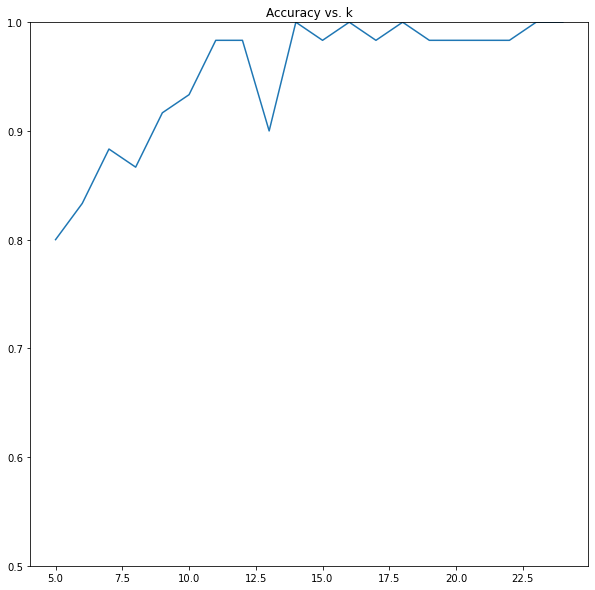

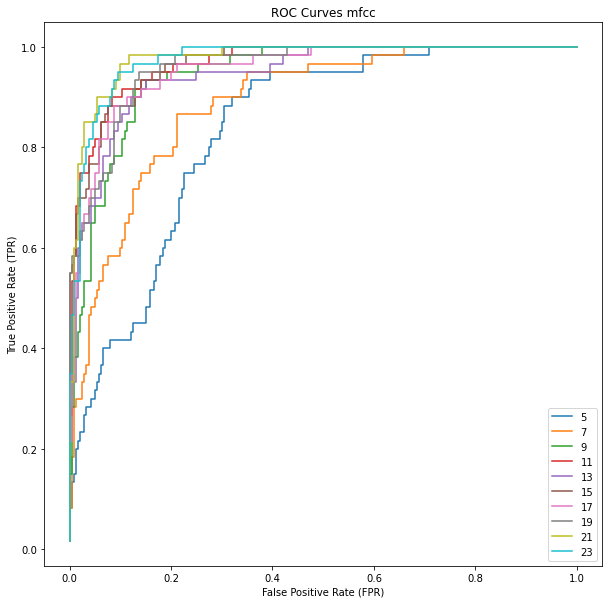

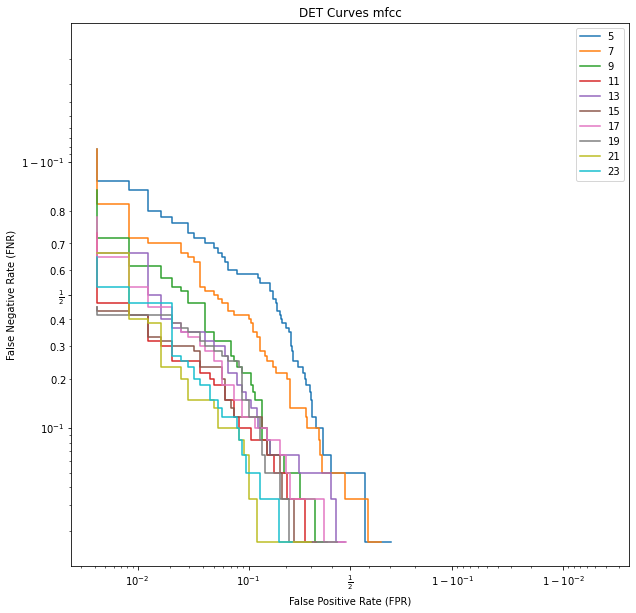

In [45]:
# MFCC HMM Plots (Acc vs k, ROC, DET)
plt.figure(figsize=[10,10])
plt.plot(k_range, acc_vs_k)
plt.title("Accuracy vs. k")
plt.ylim(0.5,1.0)
plt.savefig(f"./Plots/Acc_vs_k_{pr_type}_{algo}.png")
plt.show()

# Plot ROC for select k
str_k_range = [str(v) for v in k_range]
fig1, ax1 = plt.subplots(figsize=[10,10])
fig2, ax2 = plt.subplots(figsize=[10,10])

skip = 2

# Sort in ascending order
for case in range(len(k_range)):
    K = k_range[case]
    posts_list = posts_ll[K]
    posts_list = sorted(posts_list)
    # print(posts_list)
    roc_pts = [[0,0]]
    fp_total = []
    tp_fn_cts = [0]  #  tp_fn_cts[i] = no. of examples left of (and excluding) i which can be only tp or fn
    tn_fp_cts = [0]

    for i in range(len(posts_list)):
        post_here = posts_list[i]
        if post_here[1] == post_here[2]:
            tp_fn_cts.append(tp_fn_cts[-1] + 1)
            tn_fp_cts.append(tn_fp_cts[-1])
        else:
            tp_fn_cts.append(tp_fn_cts[-1])
            tn_fp_cts.append(tn_fp_cts[-1] + 1)

    # print(tp_fn_cts)
    # print(tn_fp_cts)
    tp_fn_tot = tp_fn_cts[-1]
    tn_fp_tot = tn_fp_cts[-1]
    tpr = []
    fpr = []
    tnr = []
    fnr = []
    ex_ct = len(posts_list)
    for i in range(len(posts_list)):

        thresh = posts_list[i][0]
        tpr.append((tp_fn_tot - tp_fn_cts[i])/tp_fn_tot)
        fpr.append((tn_fp_tot - tn_fp_cts[i])/tn_fp_tot)
        tnr.append(tn_fp_cts[i]/tn_fp_tot)
        fnr.append(tp_fn_cts[i]/tp_fn_tot)

    # roc_pts = [[fpr[i],tpr[i]] for i in range(len(tpr))]
    if case%skip == 0:
        ax1.plot(fpr, tpr)
        ax2.plot(fpr, fnr)
ax1.legend(str_k_range[::skip])
ax2.legend(str_k_range[::skip])
ax1.set_xlabel('False Positive Rate (FPR)')
ax1.set_ylabel('True Positive Rate (TPR)')

ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('False Negative Rate (FNR)')

ax2.set_xscale('logit')
ax2.set_yscale('logit')

# scale = 2
# ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale))
# ax2.xaxis.set_major_formatter(ticks)
# ax2.yaxis.set_major_formatter(ticks)

ax1.set_title("ROC Curves " + pr_type)
ax2.set_title("DET Curves " + pr_type)

fig1.savefig(f"./Plots/ROC_{pr_type}_{algo}.png")
fig2.savefig(f"./Plots/DET_{pr_type}_{algo}.png")
plt.show()


# Plot DET for select k

In [23]:
# TODOs

# TODO ROC, DET, Confusion Matrices for DTW
# TODO Connected Spoken Digits
# TODO Connected Handwritten Characters